In [1]:
import numpy as np
from dwave.system import LeapHybridSampler
from dwave.samplers import SimulatedAnnealingSampler
from dimod import ExactCQMSolver

from modules.solvers import QuantumAnnealing

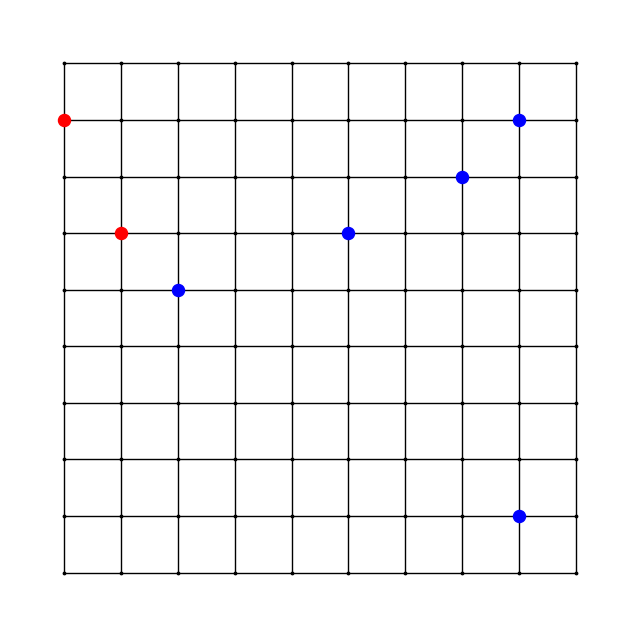

In [2]:
SHAPE = (30,30)
POI = 15
CHARGERS = 4
NEW_CHARGERS = 6

SHAPE = (10,10)
POI = 5
CHARGERS = 2
NEW_CHARGERS = 4

SEED = 42

qa = QuantumAnnealing(SHAPE, POI, CHARGERS, NEW_CHARGERS, hyperparams=np.array([2, 7, 7, 2]))
qa.draw_grid()

In [3]:
#hyper = qa.search_hyperparams([4, 3, 3, 3], num_reads=1)

In [4]:
bqm = qa.build_bqm()

In [5]:
print(bqm.quadratic)

{(1, 0): 4.000557954951879, (2, 0): 4.004043690601011, (2, 1): 6.453066225001849, (3, 0): 4.380302554492707, (3, 1): 4.105570595593982, (3, 2): 4.380302554492707, (4, 0): 4.105570595593982, (4, 1): 6.453066225001849, (4, 2): 8.392411626439793, (4, 3): 6.453066225001849, (5, 0): 8.392411626439793, (5, 1): 4.000557954951879, (5, 2): 4.004043690601011, (5, 3): 6.453066225001849, (5, 4): 4.105570595593982, (6, 0): 5.085220551453698, (6, 1): 4.000000019674738, (6, 2): 4.0000003621410585, (6, 3): 4.023214492670731, (6, 4): 4.000060984975021, (6, 5): 5.085220551453698, (7, 0): 4.023214492670731, (7, 1): 4.0000003621410585, (7, 2): 4.000005280184045, (7, 3): 4.105570595593982, (7, 4): 4.000557954951879, (7, 5): 4.380302554492707, (7, 6): 6.453066225001849, (8, 0): 4.000000019674738, (8, 1): 5.085220551453698, (8, 2): 4.023214492670731, (8, 3): 4.004043690601011, (8, 4): 4.023214492670731, (8, 5): 4.000005280184045, (8, 6): 4.000557954951879, (8, 7): 4.004043690601011, (9, 0): 4.000000019674738

Score:  74.77481569142547


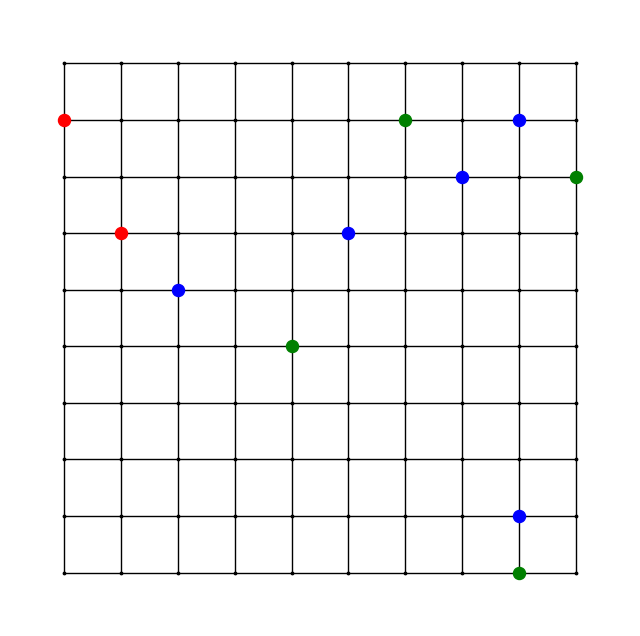

In [8]:
# Calculate score
sampleset = qa.run_bqm(bqm)
score = qa.score_sampleset(sampleset)

# Create scenario output image
print("Score: ", score)
qa.draw_grid()